### Ames Iowa Housing Project
In the realm of data science, understanding patterns and trends in real estate markets is a complex yet rewarding endeavor. The Ames Housing dataset, a rich compilation of residential property sales in Ames, Iowa from 2006 to 2010, provides an expansive platform for such an exploration. The dataset, meticulously compiled by Dean De Cock, stands as an instrumental tool for data science students seeking to explore the intricacies of regression analysis. It offers an alternative, yet more comprehensive, dataset to the Boston Housing dataset, long considered a staple in the data science education realm.

The present analysis aims to delve into this Ames Housing dataset, exploring the relationships that exist between a diverse array of property features and their corresponding market prices. 

The objective is to unearth underlying patterns and extract meaningful insights that could potentially influence decision-making processes in real estate markets. We posit that understanding the specific characteristics that influence housing prices will shed light on market trends and buyer preferences, ultimately aiding stakeholders in making more informed and strategic decisions.

The subsequent sections outline our analytical journey – the methodologies employed, tools and techniques harnessed, and the insights gleaned from our exploration. We believe that these findings will be instrumental in answering our primary business question: How do various features of a property relate to its market price? And more importantly, what implications do these relationships have for homeowners, buyers, and real estate investors alike?

### Let's start

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import probscale
from sklearn.manifold import TSNE

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import statsmodels.api as sm
from sklearn import metrics, linear_model
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from statsmodels.graphics.gofplots import qqplot
from scipy import stats
from scipy.stats import shapiro

In [3]:
data = pd.read_csv('train_eng.csv')
data_test = pd.read_csv('test_eng.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SalePrice        1460 non-null   int64  
 1   Age              1460 non-null   int64  
 2   GrLivArea        1460 non-null   int64  
 3   BaseLivArea      1460 non-null   int64  
 4   Location         1460 non-null   float64
 5   Amenities        1460 non-null   int64  
 6   RoadRail         1460 non-null   int64  
 7   BedroomAbvGr     1460 non-null   int64  
 8   Bathrooms        1460 non-null   float64
 9   OverallCond      1460 non-null   int64  
 10  OverallQual      1460 non-null   int64  
 11  LotFrontage      1460 non-null   float64
 12  LotArea          1460 non-null   int64  
 13  TwoStory_dum     1460 non-null   int64  
 14  FlatContour_dum  1460 non-null   int64  
 15  FlatRoof_dum     1460 non-null   int64  
 16  GarageArea       1460 non-null   int64  
 17  Garage_dum    

In [5]:
data_test.isnull().sum(axis=0)

Age                0
GrLivArea          0
BaseLivArea        1
Location           0
Amenities          0
RoadRail           0
BedroomAbvGr       0
Bathrooms          0
OverallCond        0
OverallQual        0
LotFrontage        0
LotArea            0
TwoStory_dum       0
FlatContour_dum    0
FlatRoof_dum       0
GarageArea         1
Garage_dum         0
CentralAirNum      0
LowQualFinSF       0
Fireplaces         0
dtype: int64

In [6]:
data_test = data_test.loc[~ np.isnan(data_test.BaseLivArea.values), :]
data_test = data_test.loc[~ np.isnan(data_test.GarageArea.values), :]


In [7]:
data.isnull().values.any(), data_test.isnull().values.any()

(False, False)

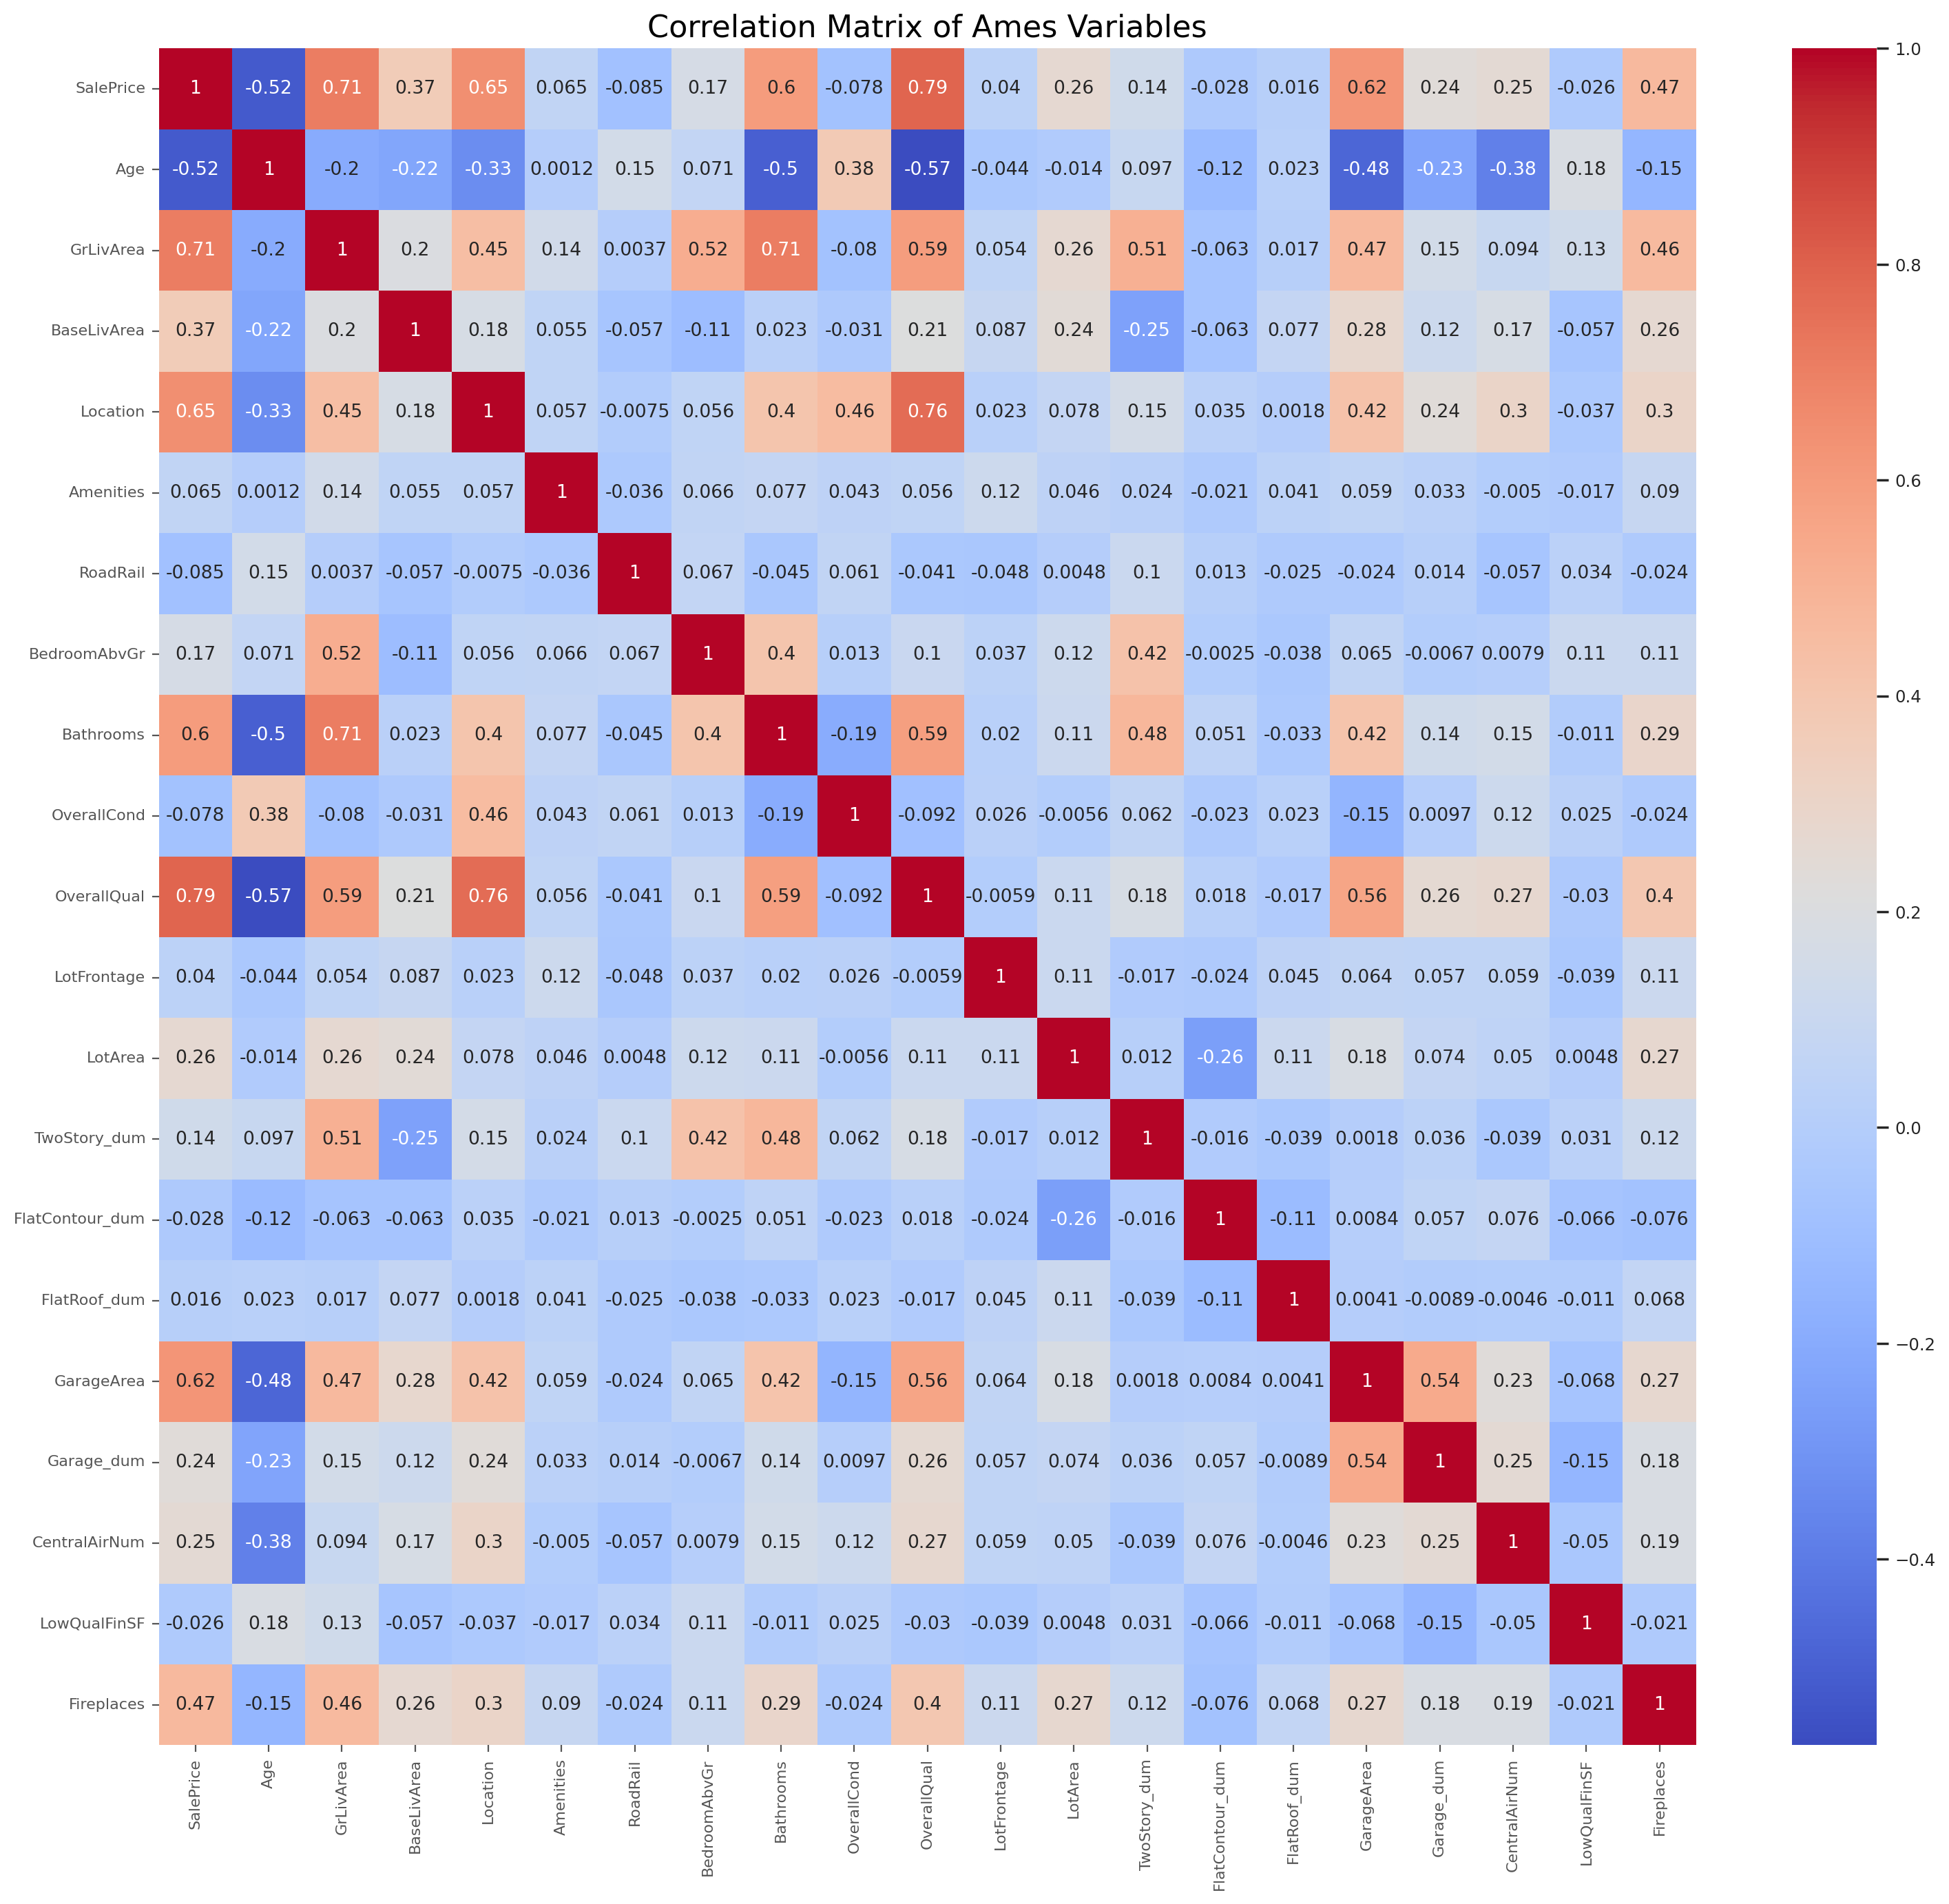

In [8]:
fig, ax = plt.subplots(figsize=(18, 16))

sns.set(font_scale=0.8)
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', ax=ax)
ax.set_title("Correlation Matrix of Ames Variables", fontsize=16)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=8)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=8)
plt.show()

The correlation matrix shows that the explanatory variables tend not to have high correlations with each other. The explanatory variable pairs that exhibit correlations is bigger than 0.70 is GrLivArea-Bathrooms. Bathrooms also has elevated correlation with Age. Given this, I decided to drop Bathrooms from the regression analysis.

In [9]:
data = data.drop(['Bathrooms'], axis=1)

# Functions
To streamline our analysis, we defined a set of Python functions that help us evaluate our models. These functions calculate various metrics and generate visualizations that help us understand our model's performance.

The 'train_scores' function takes a fitted model and the training data as inputs and calculates the model's score on the training data. It also performs 5-fold cross-validation, where the training set is split into 5 parts, the model is trained on 4 of these parts, and validated on the remaining part. This process is repeated 5 times with different partitions. The function outputs the model's training score, the individual cross-validation scores, and their mean.

In [10]:
def train_scores(model, X, y):
    '''
    model: fitted model
    X: Matrix of explanatory variables (train set)
    y: Dependant variable (train set)
    '''
    cv_scores = cross_val_score(model, X, y, cv=5) # 5-fold cross-validation

    print('Training Score:', np.round(model.score(X, y), 4))
    print('Cross-validation scores:', np.round(cv_scores, 4))
    print('Mean cross-validation score:', np.round(cv_scores.mean(), 4))

The 'test_scores' function calculates the model's score on the test data. This gives us an idea of how well our model generalizes to unseen data, which is crucial for assessing its practical usefulness.

In [11]:
def test_scores(model, X, y):
    '''
    model: fitted model
    X: Matrix of explanatory variables (test set)
    y: Dependant variable (test set)
    '''
    print('Test Score:', np.round(model.score(X, y), 4))

The 'accuracy_scores' function calculates two important metrics for regression problems. The Mean Squared Error (MSE) is the average of the squares of the differences between the predicted and actual values, and the Root Mean Squared Error (RMSE) is the square root of the MSE. RMSE is particularly useful because it is in the same units as the target variable, making it easier to interpret.

In [12]:
def accuracy_scores(model, X, y):
    '''
    model: fitted model
    X: Matrix of explanatory variables (test set)
    y: Dependant variable (test set)
    '''
    yhat = model.predict(X)
    print('Mean Squared Error:', np.round(metrics.mean_squared_error(y, yhat), 4)) 
    print('Root Mean Squared Error:', np.round((metrics.mean_squared_error(y, yhat))**0.5, 4)) 

Finally, the 'resid_histogram' function creates a histogram of the residuals, which are the differences between the predicted and actual values. This visualization helps us understand the distribution of these errors. Ideally, we want our residuals to be normally distributed around zero, indicating that our model's predictions are unbiased.

In [13]:
def resid_histogram(model, X, y, period=''):
    '''
    model: fitted model
    X: Matrix of explanatory variables
    y: Dependant variable
    period: String describing data coverage period
    '''

    yhat = model.predict(X)
    residuals = y - yhat

    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(residuals, bins=50, kde=True, ax=ax)
    plt.title(f'Residuals, {period}', fontsize=18);

To prepare our data for analysis, we separate our dataset into a matrix of explanatory variables, X, and a dependent variable vector, y. The explanatory variables are the features we use to predict the target variable, the sale price of the house.

In [14]:
X = data.drop(['SalePrice'], axis=1)
y = data['SalePrice']

### t-SNE Analysis
For the analysis, we wanted to visualize our high-dimensional dataset in a two-dimensional space to better understand the structure and relationships between different variables. To achieve this, t-SNE, short for t-distributed stochastic neighbor embedding was applied. This technique allowed us to reduce the dimensionality of our data while preserving the relationships between instances. 

In [15]:
import time 


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1460 samples in 0.001s...
[t-SNE] Computed neighbors for 1460 samples in 0.171s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1460
[t-SNE] Computed conditional probabilities for sample 1460 / 1460
[t-SNE] Mean sigma: 381.742777
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.193703
[t-SNE] KL divergence after 300 iterations: 1.145332
t-SNE done! Time elapsed: 1.7886371612548828 seconds


Our t-SNE computation took about 1.79 seconds to compute, suggesting that it handled our dataset's size efficiently. The resulting visualization, which I'll show next, helped us identify clusters and trends that wouldn't be visible in the original high-dimensional space.

<Figure size 1000x800 with 0 Axes>

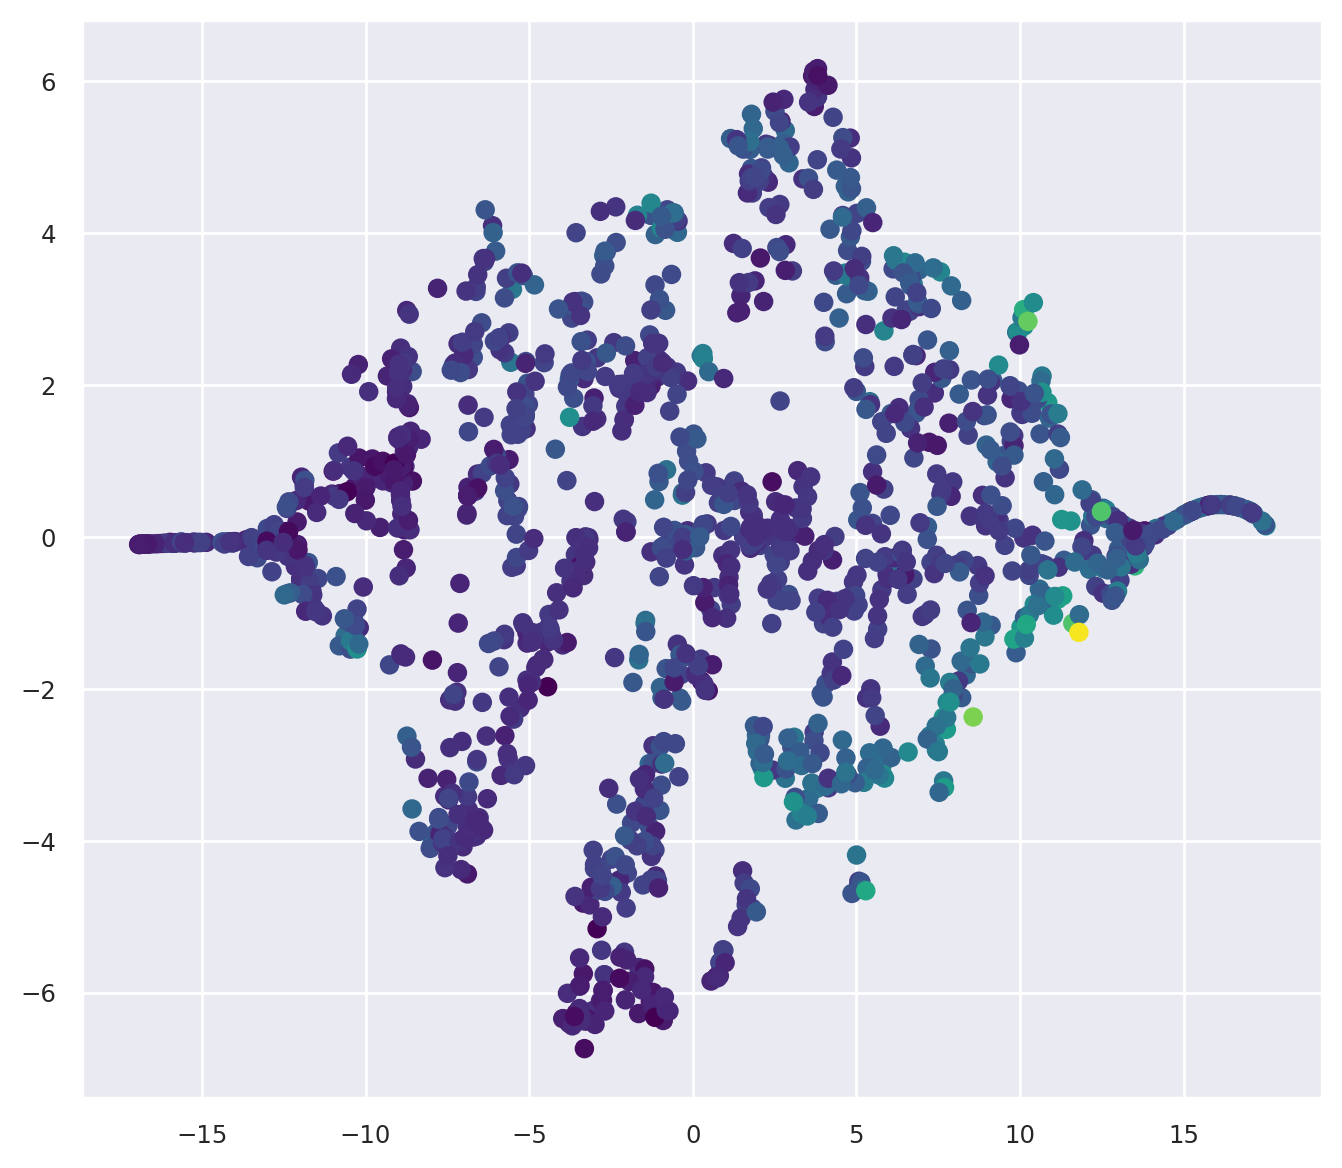

In [16]:
df_subset = pd.DataFrame()
df_subset['Sale Price'] = y
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(10, 8))
vmin, vmax = np.min(y), np.max(y)

cmap = plt.cm.viridis

norm=plt.Normalize(vmin=vmin, vmax=vmax)

plt.figure(figsize=(8,7))
plt.scatter(df_subset["tsne-2d-one"].values, df_subset["tsne-2d-two"].values, c=y,
            norm=norm, cmap=cmap,
)

plt.show()

Here we can see the result of applying t-SNE to our housing data. Each point in the scatterplot represents a house, and its color represents its price, with dark purple indicating low prices and yellow indicating high prices. This visualization helps us understand the structure of our data and can reveal patterns that might not be apparent in higher dimensions.

### Regression using SVR
After preparing our data, Support Vector Regression was applied, a type of machine learning model that uses support vectors to perform linear regression in a higher dimensional phase. 

In [17]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(n_quantiles=10, random_state=2023)
price_q =  qt.fit_transform(y.values.reshape((-1,1)))

In [18]:
# Train-test split
from sklearn.model_selection import StratifiedKFold

X = data.drop(['SalePrice'], axis=1).values
y = data['SalePrice'].values

skf = StratifiedKFold(n_splits=4)

train_index, test_index = list(skf.split(X, y))[0]

X_train, X_test, y_train, y_test = X[train_index.tolist()], X[test_index.tolist()], \
            y[train_index.tolist()], y[test_index.tolist()]


/home/maxim/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
# Fitting SCR
from sklearn.svm import SVR


model = SVR(C=1.0)
model.fit(X_train, y_train)

# SCR training set scores, including CV scores
train_scores(model, X_train, y_train)

Training Score: -0.0492
Cross-validation scores: [-0.1697 -0.0459 -0.0292 -0.014  -0.0461]
Mean cross-validation score: -0.061


The training score we got was -0.0492, and the mean cross-validation score was -0.061, which indicates that our model might not be performing optimally. It's important to note that SVR scores can be negative, which indicates a poorer fit to the data. However, the closely matched cross-validation scores, both normal and shuffled, suggest our model is consistent across different subsets of our data.

In [21]:
# Shuffled 5-fold cross validation scores are rather similar
cv_scores_shuffled = cross_val_score(model, X_train, y_train, cv=skf)

print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

/home/maxim/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


Shuffled cross validation score: [-0.0604 -0.019  -0.0618 -0.084 ]
Mean shuffled cross validation score: -0.0563


In [22]:
# SCR test set score
test_scores(model, X_test, y_test)

Test Score: -0.02


In [23]:
# SCR MSE & RMSE scores
accuracy_scores(model, X_test, y_test)

Mean Squared Error: 4121670422.0135
Root Mean Squared Error: 64200.2369


To evaluate the performance of our model, I used several metrics. First, we looked at the test score, which was -0.02. Again, this negative score suggests our model could be improved. Then we calculated the Mean Squared Error or MSE, which came to approximately 4.12 billion. This is a measure of the average squared difference between our model's predictions and the actual values, so a lower value would indicate a better fit. Finally, we calculated the Root Mean Squared Error or RMSE, which was approximately 64,200. This metric, essentially the square root of the MSE, is particularly useful because it's in the same units as our target variable, house prices. This high RMSE suggests that our model's predictions could be off by about $64,200 on average, indicating that there's significant room for improvement in our model.

### Analysis of the SVR residuals

In [24]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

In [25]:
# Descriptive statistics of training set residuals
residuals = pd.DataFrame({'residuals': (y_train - predictions_train)})
residuals_test = pd.DataFrame({'residuals': (y_test - predictions_test)})
residuals.describe()

,residuals
count,1.095000e+03
mean,1.880617e+04
std,8.389662e+04
min,-1.295323e+05
25%,-3.445971e+04
50%,-3.872556e-07
75%,5.044625e+04
max,5.904874e+05


Residuals, the difference between observed and predicted values, can give us valuable insights into our model's performance. Looking at the descriptive statistics of the residuals from our SVR model, we notice some interesting patterns. The mean residual is approximately $18,806, suggesting our predictions are generally overestimating the house prices. 

In [26]:
# Acceptable skew and kurtosis values
print("Skew:", residuals.skew())
print("Kurtosis:", residuals.kurtosis())
stat, p = shapiro(residuals)
print('Shapiro-Wilk test on normality=%.3f, p=%.3f' % (stat, p))

Skew: residuals    1.952125
dtype: float64
Kurtosis: residuals    6.604743
dtype: float64
Shapiro-Wilk test on normality=0.858, p=0.000


Furthermore, the residuals have a skewness of 1.95 and kurtosis of 6.60, indicating a long right tail and leptokurtic distribution, meaning it has heavy tails and a sharp peak. The Shapiro-Wilk test further confirms our residuals aren't normally distributed, a crucial assumption for regression models, indicating our SVR model may not be the best fit for this data.

/tmp/ipykernel_15603/4132431661.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals, bins=50, kde=True, ax=ax)


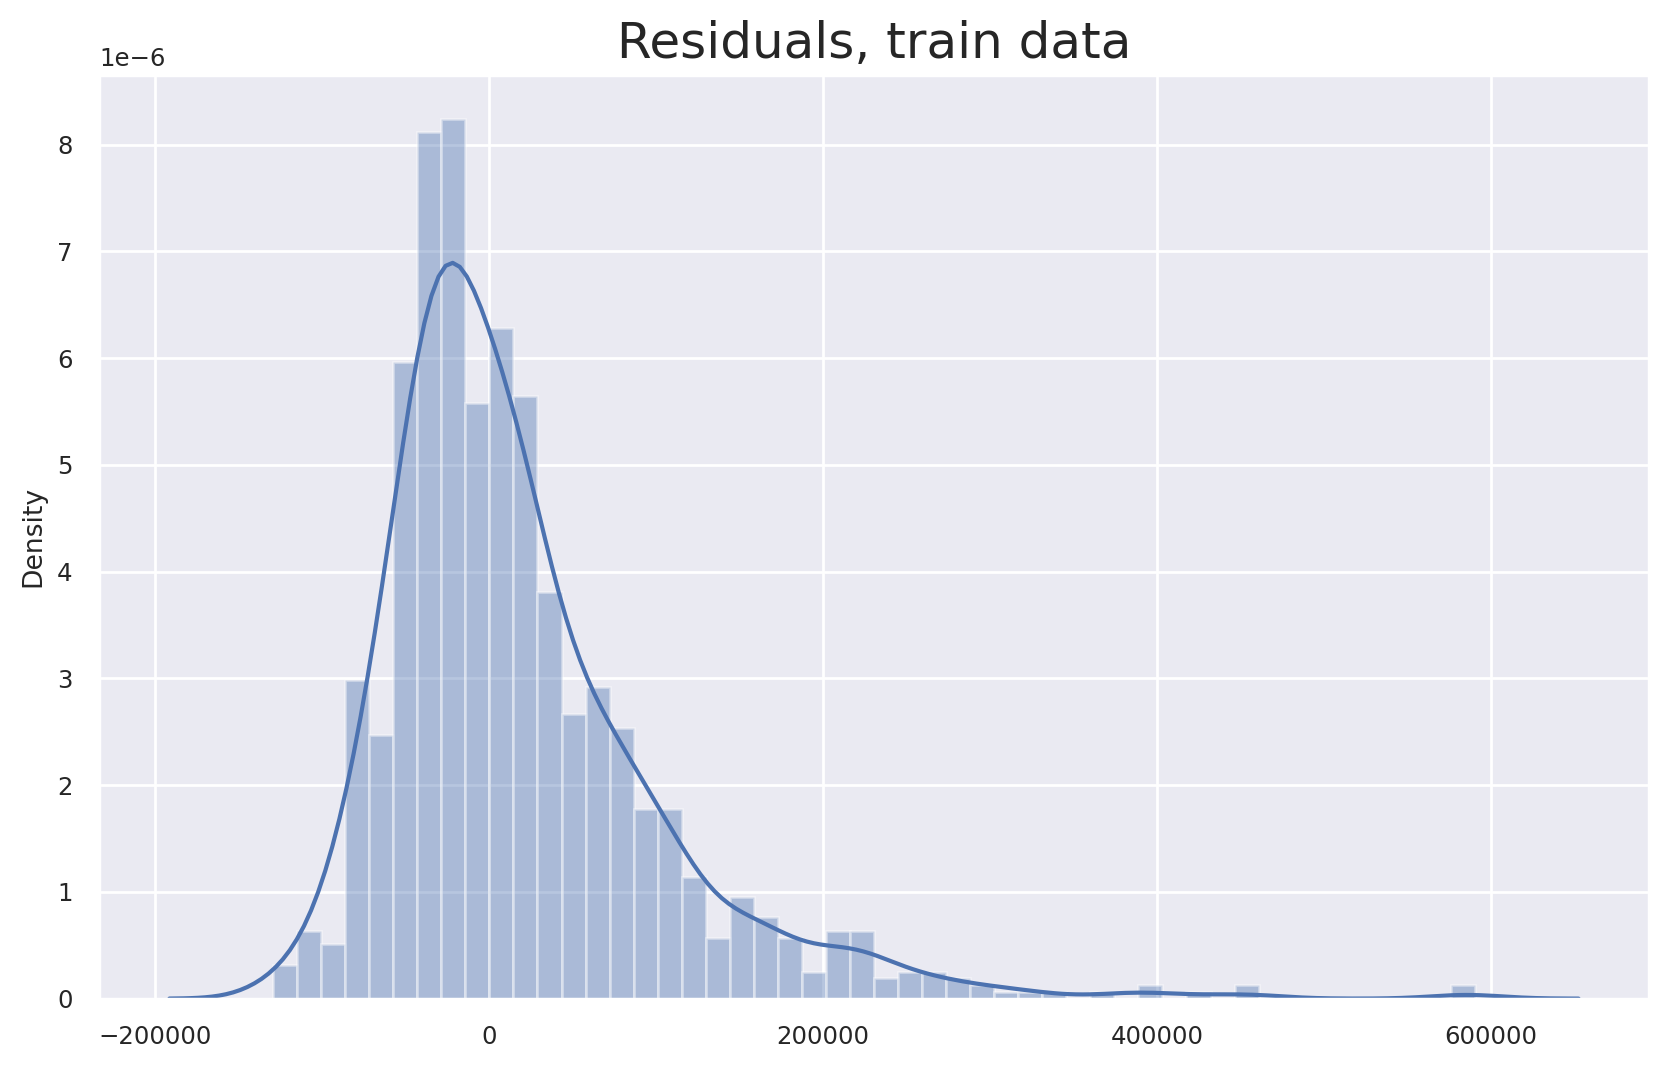

In [27]:
# Histogram of training set residuals show that they are approximately normally distributed with mean 0
# There is an indication of a left-tail, indicating that the model overpredicts the target variable
# at the very low end of 'LnSalePrice'
resid_histogram(model, X_train, y_train, period='train data')

Moving on to our Ridge model, we see an improvement in the distribution of residuals. There's still a slight left tail, indicating some overprediction at the lower end, but the distribution is more concentrated around zero, indicating better overall prediction accuracy.

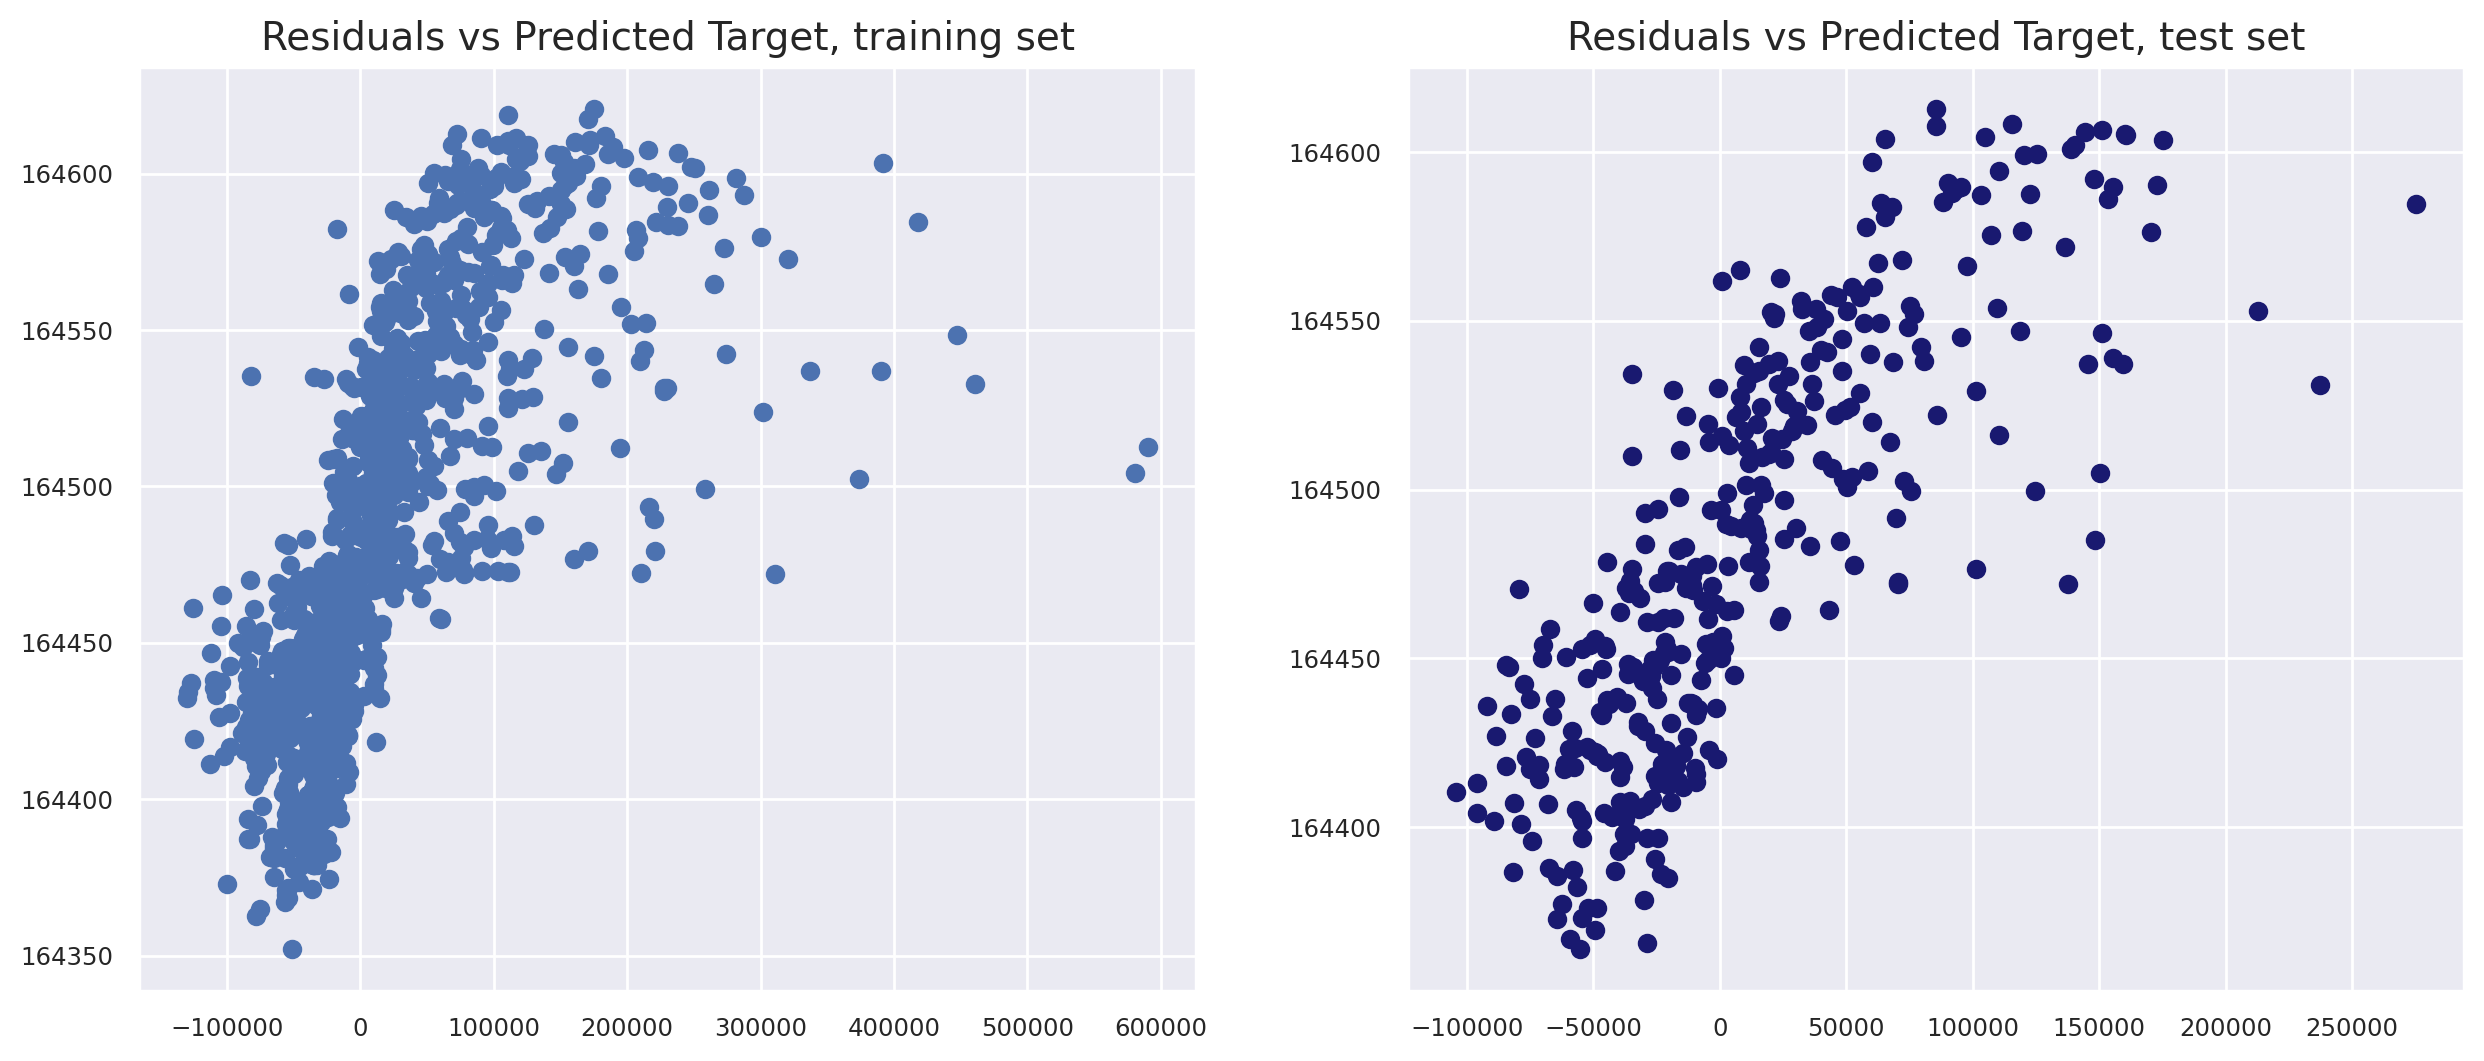

In [28]:
# Plotting the residuals against the predicted-y and 'GrLivArea'. The residuals appear well-behaved
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))
ax[0].scatter(residuals, predictions_train)
ax[0].set_title('Residuals vs Predicted Target, training set', fontsize=14)
ax[1].scatter(residuals_test, predictions_test, color='midnightblue')
ax[1].set_title('Residuals vs Predicted Target, test set', fontsize=14);

Finally, comparing the residuals to the predicted prices for our Ridge model, we see a more random scatter of points in both the training and test sets, indicating better performance and generalization. The outliers in the test set have been reduced, showing that our Ridge model is more robust in predicting a wider range of house prices.

### Regression using Ridge
To address the shortcomings of our SVR model, we decided to try Ridge Regression, a technique that introduces a small amount of bias to reduce variance and improve model generalization. We used cross-validation to find the optimal regularization parameter. 

In [29]:
# Fitting SCR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV

model = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=5)
model.fit(X_train, y_train)

# SCR training set scores, including CV scores
train_scores(model, X_train, y_train)

Training Score: 0.7865
Cross-validation scores: [0.8475 0.7625 0.791  0.7758 0.4913]
Mean cross-validation score: 0.7336


In [30]:
# Shuffled 5-fold cross validation scores are rather similar
cv_scores_shuffled = cross_val_score(model, X_train, y_train, cv=skf)

print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

/home/maxim/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


Shuffled cross validation score: [0.7827 0.7907 0.5985 0.8252]
Mean shuffled cross validation score: 0.7493


In [31]:
# SCR test set score
test_scores(model, X_test, y_test)

Test Score: 0.8391


In [32]:
# SCR MSE & RMSE scores
accuracy_scores(model, X_test, y_test)

Mean Squared Error: 650153396.7371
Root Mean Squared Error: 25498.1057


The Ridge model shows a significant improvement in performance, with a training score of 0.7865, and a mean cross-validation score of 0.7336. The test score further increased to 0.8391, suggesting that our model generalizes well to unseen data. The MSE and RMSE also reduced dramatically to 650,153,396 and 25,498 respectively, showing that our predictions are now much closer to the actual values.

### Analysis of the Ridge residuals
Looking at the residuals of our Ridge model, we see a significant improvement. 

In [33]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

In [34]:
# Descriptive statistics of training set residuals
residuals = pd.DataFrame({'residuals': (y_train - predictions_train)})
residuals_test = pd.DataFrame({'residuals': (y_test - predictions_test)})
residuals.describe()

,residuals
count,1.095000e+03
mean,3.614722e-12
std,3.878342e+04
min,-4.972473e+05
25%,-1.850504e+04
50%,-3.492214e+03
75%,1.254067e+04
max,2.901698e+05


In [35]:
# Acceptable skew and kurtosis values
print("Skew:", residuals.skew())
print("Kurtosis:", residuals.kurtosis())
stat, p = shapiro(residuals)
print('Shapiro-Wilk test on normality=%.3f, p=%.3f' % (stat, p))

Skew: residuals   -0.454077
dtype: float64
Kurtosis: residuals    37.455871
dtype: float64
Shapiro-Wilk test on normality=0.736, p=0.000


The mean is extremely close to zero, indicating that on average, our model's predictions are accurate. The skewness is now -0.454, suggesting a slight left tail, and the kurtosis has increased to 37.46, indicating a very heavy-tailed distribution. The Shapiro-Wilk test still indicates non-normality, but overall, our Ridge model's residuals show a significant improvement over our SVR model, confirming that Ridge Regression is a better fit for our data.

#### Residuals Histogram - Ridge

/tmp/ipykernel_15603/4132431661.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals, bins=50, kde=True, ax=ax)


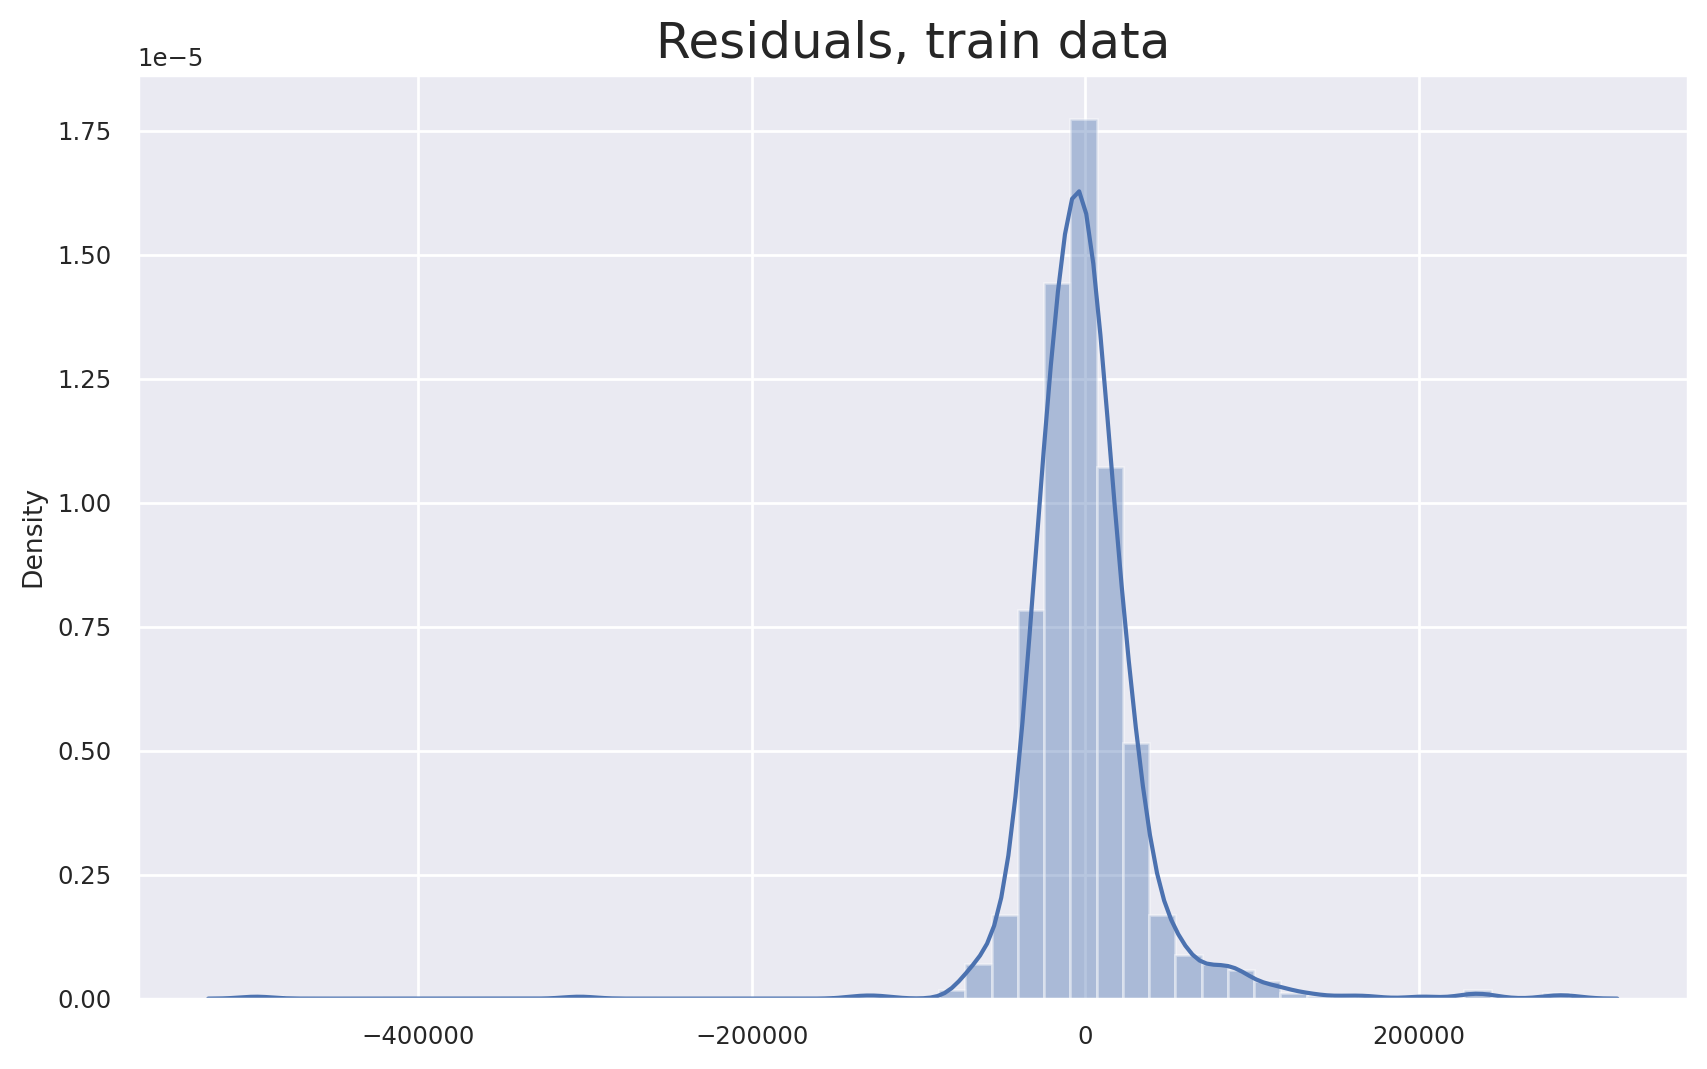

In [36]:
# Histogram of training set residuals show that they are approximately normally distributed with mean 0
# There is an indication of a left-tail, indicating that the model overpredicts the target variable
# at the very low end of 'LnSalePrice'
resid_histogram(model, X_train, y_train, period='train data')

Moving on to our Ridge model, we can see an improvement in the distribution of residuals. There's still a slight left tail, indicating some overprediction at the lower end, but the distribution is more concentrated around zero, indicating better overall prediction accuracy.

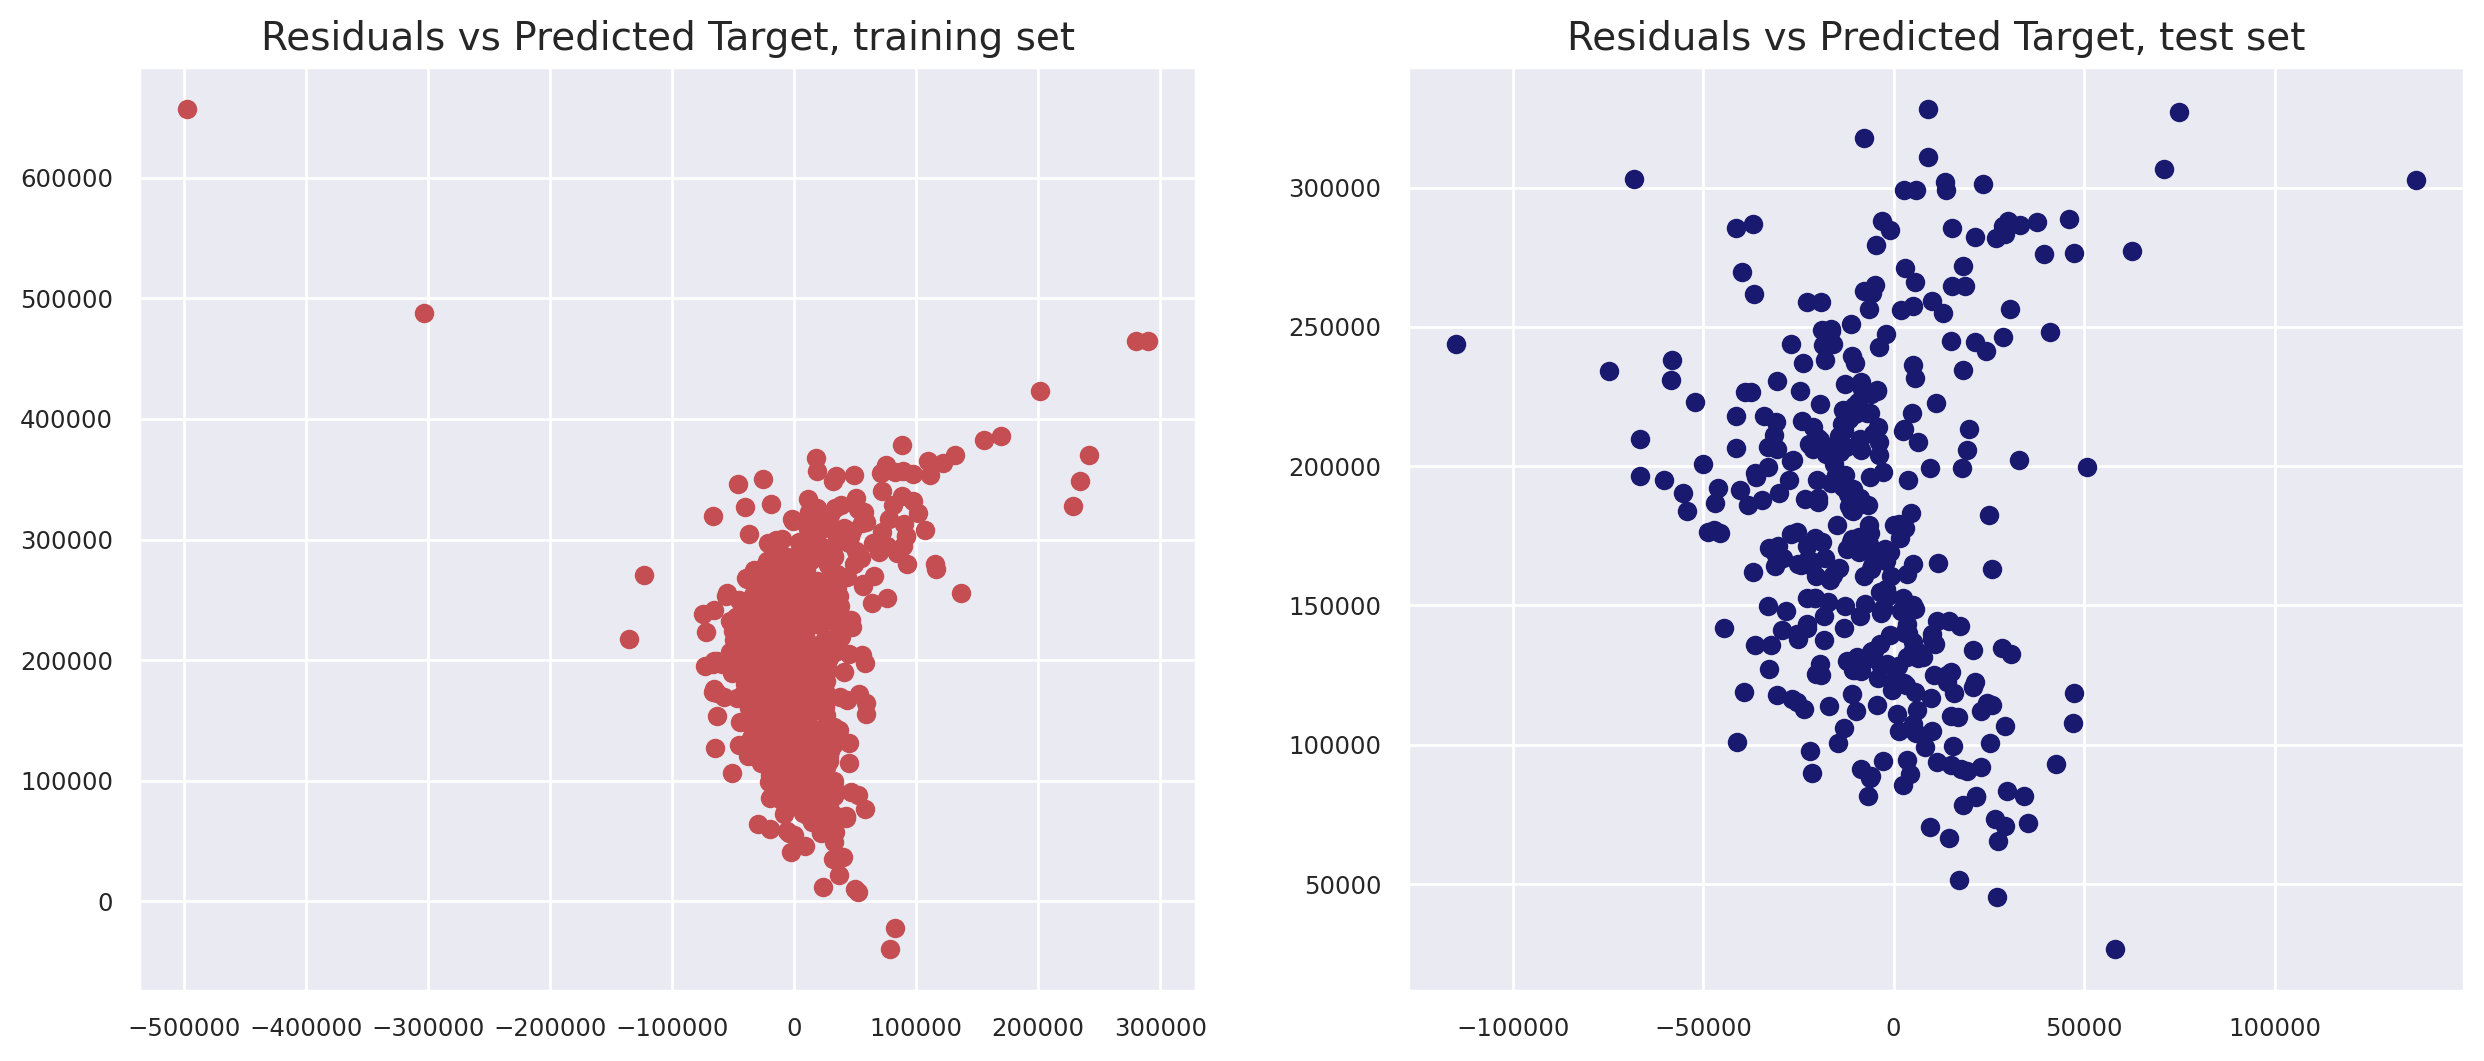

In [39]:
# Plotting the Ridge residuals against the predicted-y and 'GrLivArea'. The residuals appear well-behaved
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))
ax[0].scatter(residuals, predictions_train, color='r')
ax[0].set_title('Residuals vs Predicted Target, training set', fontsize=14)
ax[1].scatter(residuals_test, predictions_test, color='midnightblue')
ax[1].set_title('Residuals vs Predicted Target, test set', fontsize=14);

Finally, comparing the residuals to the predicted prices for our Ridge model, we see a more random scatter of points in both the training and test sets, indicating better performance and generalization. The outliers in the test set have been reduced, showing that our Ridge model is more robust in predicting a wider range of house prices.

### Interpretations
Interpreting the findings, we can see that the clusters identified in the t-SNE analysis imply that properties with similar features often have similar prices. The lower performance of the SVR model suggests that there might be linear relationships between some of the features and the target variable. The Ridge Regression model's superior(se-perio) performance underscores the value of regularization techniques in reducing overfitting and enhancing model generalization. The overestimation of lower house prices by both models could hint at outliers or other factors not covered in the models, warranting further investigation.

### Recommendations & Conclusions
In conclusion, refining the current models or exploring alternative techniques to better address the overestimation of lower house prices is recommend. Additional research should be carried out to uncover other potential influences on house prices, such as broader economic indicators or specific neighborhood characteristics. It's crucial that strategic decisions in real estate take into account the significant property features identified in this study. We believe the insights from this analysis can greatly assist in creating more informed and strategic decision-making processes in the real estate market.